# Описание

**Цель**: Разработка системы для прогнозирования стоимости акций компании Yandex на бирже Tinkoff.

**Задачи:**
1. Работа с данными
    * Анализ данных
    * Добавление новых дата-фичей, выделение таргета
    * Корреляционный анализ
2. Построение моделей
    * Базовая модель
        * Построение модели линейной регрессии
        * Регрессионный анализ
        * Визуализация результата
    * Градиентный бустинг
        * Построение модели градиентного бустинга над решающими деревьями
        * Подбор гиперпараметров
        * Визуализация результата
    * Рекуррентные нейронные сети
        * Подготовка данных
        * Построение модели с LSTM слоями
        * Визуализация результата
        * Построение модели с GRU слоями
        * Визуализация результата
        * Подбор гиперпараметров
    * ARIMA
3. Оценка моделей
    * Выбор метрик
    * Сравнение моделей и оценка качества результата
    * Визуализация результатов работы
4. Запуск выбранной модели
    * Упаковка модели в Docker-контейнер
    * Создание сервера для получения данных с биржи
    * Создание Telegram бота

**Набор технологий:**
* Numpy, Pandas, Matplotlib
* Sklearn, Tensorflow, Keras
* FastAPI, Uvicorn, Aiogram
* Tinkoff-invest

**Репозиторий:** [GitHub](https://github.com/DevVladikNT/ProfiTrade)

# Работа с данными

## Анализ данных

In [1]:
import numpy as np
import pandas as pd

In [53]:
df = pd.read_csv('/kaggle/input/yandex-stock-price-1-hour-period/yandex_1hour.csv', index_col=0)
df.head()

,date,open,high,low,close,volume
0,2018-03-07 18:00:00,2378.0,2385.0,2375.0,2385.0,836
1,2018-03-07 19:00:00,2385.5,2390.0,2380.0,2385.0,2430
2,2018-03-07 20:00:00,2385.0,2394.5,2383.0,2388.5,1452
3,2018-03-07 21:00:00,2388.5,2390.0,2381.5,2382.0,4294
4,2018-03-07 22:00:00,2384.0,2389.5,2371.5,2372.5,12904


В данном датасете представлена история изменения стоимости акций компании Yandex в формате часовых свечей, где date - дата и время соответствующего периода, open, high, low и close - цена открытия, максимальная, минимальная и цена закрытия свечи соответственно. volume - объем сделок на бирже за соответствующий временной период.

In [54]:
df.drop('date', axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15523 entries, 0 to 15522
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    15523 non-null  float64
 1   high    15523 non-null  float64
 2   low     15523 non-null  float64
 3   close   15523 non-null  float64
 4   volume  15523 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 727.6 KB


Неопределенных значений нет, всего свечей 15523.

In [2]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

import matplotlib.pyplot as plt

Частные коэффициенты автокорреляции

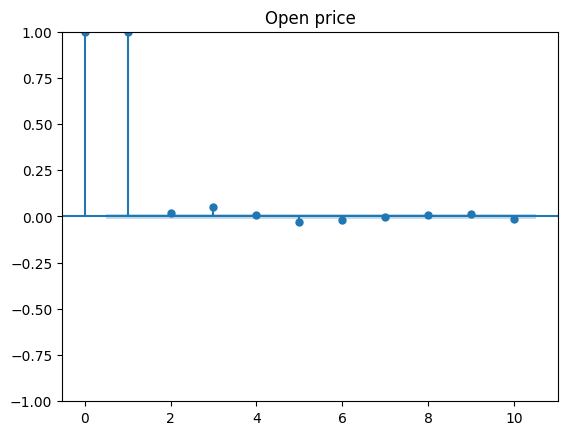

[ 1.          0.99987305  0.0317828   0.07664917  0.01208015 -0.03915255
 -0.03079518 -0.00457057  0.01296444  0.01992887 -0.02088572]


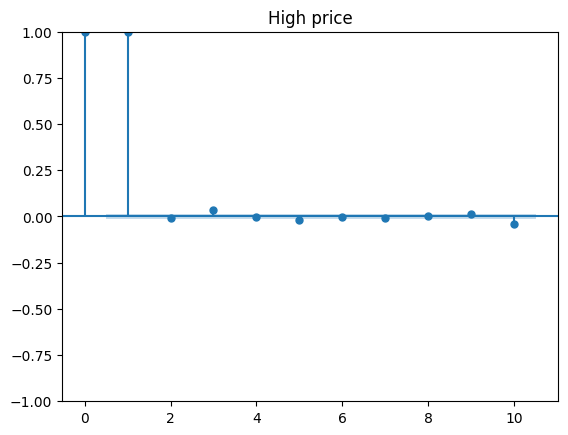

[ 1.          0.9998899  -0.01122001  0.05969255 -0.00621619 -0.02745274
 -0.00811634 -0.01264075  0.00382656  0.02291378 -0.06840308]


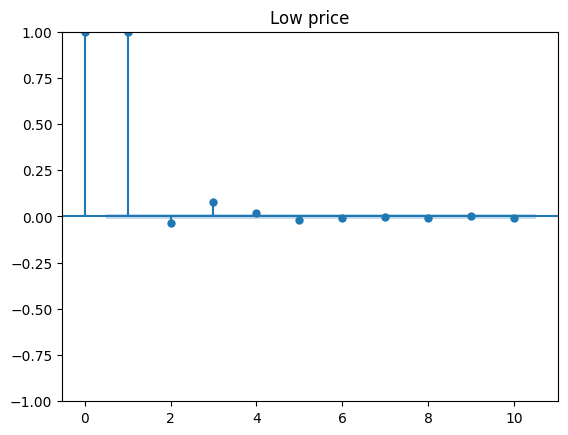

[ 1.          0.99987298 -0.05639904  0.11921866  0.02001539 -0.02301008
 -0.00625857 -0.0016199  -0.01505729  0.00750767 -0.0158702 ]


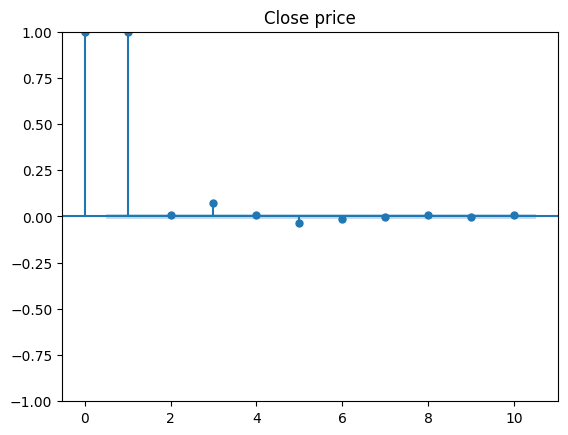

[ 1.          0.99987091  0.01517386  0.10568694  0.01113818 -0.04637678
 -0.02393256 -0.01008755  0.01410995 -0.00594178  0.01335244]


In [7]:
tsaplots.plot_pacf(df.open, lags=10)
plt.title('Open price')
plt.show()
print(k_open := sm.tsa.pacf(df.open, nlags=10))

tsaplots.plot_pacf(df.high, lags=10)
plt.title('High price')
plt.show()
print(k_high := sm.tsa.pacf(df.high, nlags=10))

tsaplots.plot_pacf(df.low, lags=10)
plt.title('Low price')
plt.show()
print(k_low := sm.tsa.pacf(df.low, nlags=10))

tsaplots.plot_pacf(df.close, lags=10)
plt.title('Close price')
plt.show()
print(k_close := sm.tsa.pacf(df.close, nlags=10))

Из графиков и значений коэффициентов корреляции видно, что максимальное значение около 0.999 имеет предыдущий период относительно рассматриваемого. Затем значения сильно падают, но до 4го находятся в пределах уровня значимости.

## Добавление новых дата-фичей

Объявляем размер окна и параметр сглаживания

In [3]:
window_size = 4
alpha = 0.5

Скользящее среднее

$$MA_t = \frac{1}{n} \sum^{n-1}_{i=0} p_{t-i}$$

In [5]:
df['open_MA'] = df['open'].rolling(window=window_size).mean()
df['high_MA'] = df['high'].rolling(window=window_size).mean()
df['low_MA'] = df['low'].rolling(window=window_size).mean()
df['close_MA'] = df['close'].rolling(window=window_size).mean()
df['volume_MA'] = df['volume'].rolling(window=window_size).mean()
df.fillna(value=0, inplace=True)

Экспоненциальное сглаживание

$$EW_t =
\left\{
    \begin{array}{ll}
        f_t  & \mbox{if } t = 0 \\
        EW_{t-1} + \alpha * (f_t - EW_{t-1}) & \mbox{if } t \gt 0
    \end{array}
\right.$$

In [6]:
df['open_EW'] = df['open'].ewm(alpha=alpha).mean()
df['high_EW'] = df['high'].ewm(alpha=alpha).mean()
df['low_EW'] = df['low'].ewm(alpha=alpha).mean()
df['close_EW'] = df['close'].ewm(alpha=alpha).mean()
df['volume_EW'] = df['volume'].ewm(alpha=alpha).mean()

In [11]:
df.head(10)

,open,high,low,close,volume,open_MA,high_MA,low_MA,close_MA,volume_MA,open_EW,high_EW,low_EW,close_EW,volume_EW
0,2378.0,2385.0,2375.0,2385.0,836,0.000,0.000,0.000,0.000,0.00,2378.000000,2385.000000,2375.000000,2385.000000,836.000000
1,2385.5,2390.0,2380.0,2385.0,2430,0.000,0.000,0.000,0.000,0.00,2383.000000,2388.333333,2378.333333,2385.000000,1898.666667
2,2385.0,2394.5,2383.0,2388.5,1452,0.000,0.000,0.000,0.000,0.00,2384.142857,2391.857143,2381.000000,2387.000000,1643.428571
3,2388.5,2390.0,2381.5,2382.0,4294,2384.250,2389.875,2379.875,2385.125,2253.00,2386.466667,2390.866667,2381.266667,2384.333333,3057.066667
4,2384.0,2389.5,2371.5,2372.5,12904,2385.750,2391.000,2379.000,2382.000,5270.00,2385.193548,2390.161290,2376.225806,2378.225806,8139.354839
5,2374.0,2379.0,2372.0,2376.5,4548,2382.875,2388.250,2377.000,2379.875,5799.50,2379.507937,2384.492063,2374.079365,2377.349206,6315.174603
6,2437.5,2439.0,2427.5,2427.5,2218,2396.000,2399.375,2388.125,2389.625,5991.00,2408.732283,2411.960630,2401.000000,2402.622047,4250.456693
7,2474.0,2474.0,2474.0,2474.0,200,2417.375,2420.375,2411.250,2412.625,4967.50,2441.494118,2443.101961,2437.643137,2438.450980,2217.286275
8,2474.0,2484.0,2451.0,2475.5,4880,2439.875,2444.000,2431.125,2438.375,2961.50,2457.778865,2463.590998,2444.334638,2457.011742,3551.248532
9,2478.0,2478.0,2466.0,2466.5,2623,2465.875,2468.750,2454.625,2460.875,2480.25,2467.899316,2470.802542,2455.177908,2461.760508,3086.670577


Выделяем таргет

In [7]:
df['target'] = df['close'].shift(-1)

In [10]:
df.head()

,open,high,low,close,volume,open_MA,high_MA,low_MA,close_MA,volume_MA,open_EW,high_EW,low_EW,close_EW,volume_EW,target
0,2378.0,2385.0,2375.0,2385.0,836,0.00,0.000,0.000,0.000,0.0,2378.000000,2385.000000,2375.000000,2385.000000,836.000000,2385.0
1,2385.5,2390.0,2380.0,2385.0,2430,0.00,0.000,0.000,0.000,0.0,2383.000000,2388.333333,2378.333333,2385.000000,1898.666667,2388.5
2,2385.0,2394.5,2383.0,2388.5,1452,0.00,0.000,0.000,0.000,0.0,2384.142857,2391.857143,2381.000000,2387.000000,1643.428571,2382.0
3,2388.5,2390.0,2381.5,2382.0,4294,2384.25,2389.875,2379.875,2385.125,2253.0,2386.466667,2390.866667,2381.266667,2384.333333,3057.066667,2372.5
4,2384.0,2389.5,2371.5,2372.5,12904,2385.75,2391.000,2379.000,2382.000,5270.0,2385.193548,2390.161290,2376.225806,2378.225806,8139.354839,2376.5


In [11]:
df.tail()

,open,high,low,close,volume,open_MA,high_MA,low_MA,close_MA,volume_MA,open_EW,high_EW,low_EW,close_EW,volume_EW,target
15518,2000.6,2006.0,1990.8,1994.2,60513,2003.70,2013.00,1984.60,1997.75,94298.25,1999.748682,2009.827152,1986.329694,1996.685755,80405.303415,2005.8
15519,1994.4,2009.0,1994.2,2005.8,45743,1999.05,2010.85,1980.15,1995.45,103108.50,1997.074341,2009.413576,1990.264847,2001.242878,63074.151708,1998.6
15520,2006.0,2015.0,1980.0,1998.6,99551,1995.50,2009.20,1986.50,1999.90,71451.50,2001.537170,2012.206788,1985.132424,1999.921439,81312.575854,1991.8
15521,1998.8,2005.4,1985.4,1991.8,51328,1999.95,2008.85,1987.60,1997.60,64283.75,2000.168585,2008.803394,1985.266212,1995.860719,66320.287927,1998.0
15522,1992.0,1998.8,1989.0,1998.0,10452,1997.80,2007.05,1987.15,1998.55,51768.50,1996.084293,2003.801697,1987.133106,1996.930360,38386.143963,NaN


Убираем первые 3 строки с нулевыми скользящими и последнюю строку с таргетом NaN

In [12]:
df = df.iloc[3:-1]

In [13]:
df.head()

,open,high,low,close,volume,open_MA,high_MA,low_MA,close_MA,volume_MA,open_EW,high_EW,low_EW,close_EW,volume_EW,target
3,2388.5,2390.0,2381.5,2382.0,4294,2384.250,2389.875,2379.875,2385.125,2253.0,2386.466667,2390.866667,2381.266667,2384.333333,3057.066667,2372.5
4,2384.0,2389.5,2371.5,2372.5,12904,2385.750,2391.000,2379.000,2382.000,5270.0,2385.193548,2390.161290,2376.225806,2378.225806,8139.354839,2376.5
5,2374.0,2379.0,2372.0,2376.5,4548,2382.875,2388.250,2377.000,2379.875,5799.5,2379.507937,2384.492063,2374.079365,2377.349206,6315.174603,2427.5
6,2437.5,2439.0,2427.5,2427.5,2218,2396.000,2399.375,2388.125,2389.625,5991.0,2408.732283,2411.960630,2401.000000,2402.622047,4250.456693,2474.0
7,2474.0,2474.0,2474.0,2474.0,200,2417.375,2420.375,2411.250,2412.625,4967.5,2441.494118,2443.101961,2437.643137,2438.450980,2217.286275,2475.5


In [17]:
df.tail()

,open,high,low,close,volume,open_MA,high_MA,low_MA,close_MA,volume_MA,open_EW,high_EW,low_EW,close_EW,volume_EW,target
15517,1981.0,2006.8,1981.0,2001.0,79999,2007.55,2017.00,1989.95,2002.30,82313.50,1998.897363,2013.654303,1981.859388,1999.171510,100297.606830,1994.2
15518,2000.6,2006.0,1990.8,1994.2,60513,2003.70,2013.00,1984.60,1997.75,94298.25,1999.748682,2009.827152,1986.329694,1996.685755,80405.303415,2005.8
15519,1994.4,2009.0,1994.2,2005.8,45743,1999.05,2010.85,1980.15,1995.45,103108.50,1997.074341,2009.413576,1990.264847,2001.242878,63074.151708,1998.6
15520,2006.0,2015.0,1980.0,1998.6,99551,1995.50,2009.20,1986.50,1999.90,71451.50,2001.537170,2012.206788,1985.132424,1999.921439,81312.575854,1991.8
15521,1998.8,2005.4,1985.4,1991.8,51328,1999.95,2008.85,1987.60,1997.60,64283.75,2000.168585,2008.803394,1985.266212,1995.860719,66320.287927,1998.0


Таким образом, рассмотрим помимо исходных значений соответствующие им скользящие средние с окном объявленным выше и значения экспоненциального сглаживания с коэффициентом 0.5.

## Корреляционный анализ

In [4]:
import seaborn as sns

<Axes: >

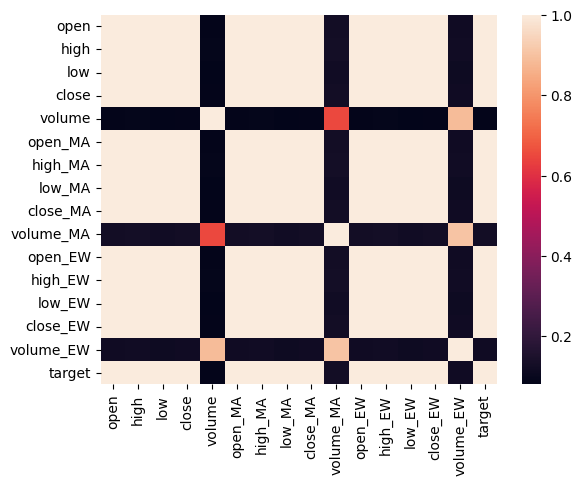

In [19]:
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

По матрице выше видно, что значения volume (и соответствующие скользящие средние и экспоненциальные сглаживания) почти не коррелируют с таргетом по сравнению с остальными дата-фичами модели.

In [20]:
df.drop(['volume', 'volume_MA', 'volume_EW'], axis=1, inplace=True)

In [21]:
df.head()

,open,high,low,close,open_MA,high_MA,low_MA,close_MA,open_EW,high_EW,low_EW,close_EW,target
3,2388.5,2390.0,2381.5,2382.0,2384.250,2389.875,2379.875,2385.125,2386.466667,2390.866667,2381.266667,2384.333333,2372.5
4,2384.0,2389.5,2371.5,2372.5,2385.750,2391.000,2379.000,2382.000,2385.193548,2390.161290,2376.225806,2378.225806,2376.5
5,2374.0,2379.0,2372.0,2376.5,2382.875,2388.250,2377.000,2379.875,2379.507937,2384.492063,2374.079365,2377.349206,2427.5
6,2437.5,2439.0,2427.5,2427.5,2396.000,2399.375,2388.125,2389.625,2408.732283,2411.960630,2401.000000,2402.622047,2474.0
7,2474.0,2474.0,2474.0,2474.0,2417.375,2420.375,2411.250,2412.625,2441.494118,2443.101961,2437.643137,2438.450980,2475.5


<Axes: >

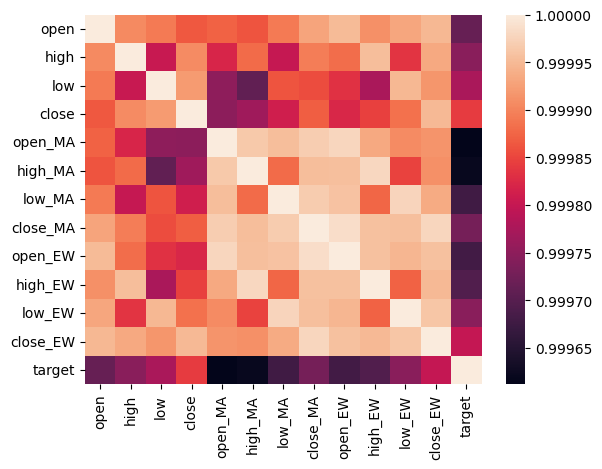

In [22]:
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Теперь матрица выглядит интереснее, но все коэффициенты очень большие (больше 0.999), поэтому не имеет смысла выделять что-то отдельно.

## Обработка данных

Берем train_size равным 0.8, а размер валидационной выборки (для подбора гиперпараметров и регрессионного анализа) и тестовой равными 0.1 обе соответственно.

In [5]:
train_size = 0.8
val_size = 0.1

In [24]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

In [25]:
print(f'train = {train.shape[0]}')
print(f'val = {val.shape[0]}')
print(f'test = {test.shape[0]}')

train = 12415
val = 1552
test = 1552


# Базовая модель

В качестве базовой модели рассмотрим самый простой и быстрый алгоритм - линейную регрессию. К тому же, с ней получится провести регрессионный анализ для отсеивания незначимых дата-фичей.

## Строим модель

In [26]:
base_train_X = train.drop('target', axis=1)
base_train_y = train['target']

base_val_X = val.drop('target', axis=1)
base_val_y = val['target']

base_test_X = test.drop('target', axis=1)
base_test_y = test['target']

In [6]:
from sklearn.linear_model import LinearRegression

In [28]:
base_model = LinearRegression()
base_model.fit(base_train_X, base_train_y)

LinearRegression()

In [3]:
from sklearn.metrics import mean_absolute_percentage_error

In [30]:
base_prediction = base_model.predict(base_test_X)
mape = mean_absolute_percentage_error(base_test_y, base_prediction)
print(f'Base model\'s MAPE = {mape * 100:.2f}%')

Base model's MAPE = 0.30%


В качестве метрики качества была выбрана MAPE. Подробнее про метрики поговорим в следующих разделах.

Однако, уже сейчас можно сказать, что результат получился неплохой. Но это только на первый взгляд; на самом деле завышенное значение метрики связано с малыми колебаниями стоимости акции в рассматриваемый период времени (предыдущие 4 часа) относительно всей стоимости акции.

In [31]:
print('Последние 100 наблюдений')
mean_price = np.mean(df.close[-100:])
mean_diff = np.mean(np.abs(df.close[-100:] - df.close.shift(1)[-100:]))
print(f'Средняя стоимость акции: {mean_price}')
print(f'Среднее изменений стоимости: {mean_diff:.2f} ({(mean_diff / mean_price) * 100:.2f}% от средней стоимости)')

Последние 100 наблюдений
Средняя стоимость акции: 2071.1839999999997
Среднее изменений стоимости: 8.46 (0.41% от средней стоимости)


Получается, что значение ошибки получившейся модели чуть лучше, чем среднее изменение стоимости акции в последнее время, что уже неплохо для базовой модели, но далеко от почти 100% результата как могло показаться изначально.

## Регрессионный анализ

Чем плох корреляционный анализ?

Тем, что он рассматривает зависимость целевой переменной от дата-фичей для каждого по отдельности не учитывая зависимости дата-фичей между собой. То есть в таком случае присутствует мультиколлинеарность.
Регрессионный анализ можно использовать для того, чтобы избавиться от описанной выше проблемы.

In [32]:
print(pd.DataFrame(base_model.coef_, index=df.columns[:-1], columns=['Coefficient']))
print(f'\nScore = {base_model.score(base_val_X, base_val_y):.4f}')

          Coefficient
open        -0.020700
high        -0.166469
low          0.079593
close        1.412813
open_MA      0.016922
high_MA     -0.312742
low_MA       0.005856
close_MA     0.657958
open_EW      0.167196
high_EW      0.454184
low_EW       0.013682
close_EW    -1.308113

Score = 0.9861


В данном случае параметры модели показывают какой вклад вносит каждая переменная в результат модели. Чем больше значение по модулю, тем более весомый вклад у каждой переменной соответственно.

Из значений выше видно, что минимальный вклад вносит дата-фича low_MA. Уберем ее и посмотрим как изменился score на валидационной выборке.

In [33]:
df.drop('low_MA', axis=1, inplace=True)

In [34]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

base_train_X = train.drop('target', axis=1)
base_train_y = train['target']
base_val_X = val.drop('target', axis=1)
base_val_y = val['target']
base_test_X = test.drop('target', axis=1)
base_test_y = test['target']

base_model = LinearRegression()
base_model.fit(base_train_X, base_train_y)

print(pd.DataFrame(base_model.coef_, index=df.columns[:-1], columns=['Coefficient']))
print(f'\nScore = {base_model.score(base_val_X, base_val_y):.4f}')

          Coefficient
open        -0.019333
high        -0.167327
low          0.077025
close        1.414784
open_MA      0.020503
high_MA     -0.315358
close_MA     0.662597
open_EW      0.162737
high_EW      0.457225
low_EW       0.021606
close_EW    -1.314280

Score = 0.9861


Видим, что скор не получил видимых изменений. Повторим процедуру по аналогии.

In [35]:
df.drop('open', axis=1, inplace=True)

In [36]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

base_train_X = train.drop('target', axis=1)
base_train_y = train['target']
base_val_X = val.drop('target', axis=1)
base_val_y = val['target']
base_test_X = test.drop('target', axis=1)
base_test_y = test['target']

base_model = LinearRegression()
base_model.fit(base_train_X, base_train_y)

print(pd.DataFrame(base_model.coef_, index=df.columns[:-1], columns=['Coefficient']))
print(f'\nScore = {base_model.score(base_val_X, base_val_y):.4f}')

          Coefficient
high        -0.180939
low          0.069464
close        1.425285
open_MA      0.035697
high_MA     -0.325866
close_MA     0.672857
open_EW      0.123176
high_EW      0.484885
low_EW       0.032384
close_EW    -1.336764

Score = 0.9861


In [37]:
df.drop('low_EW', axis=1, inplace=True)

In [38]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

base_train_X = train.drop('target', axis=1)
base_train_y = train['target']
base_val_X = val.drop('target', axis=1)
base_val_y = val['target']
base_test_X = test.drop('target', axis=1)
base_test_y = test['target']

base_model = LinearRegression()
base_model.fit(base_train_X, base_train_y)

print(pd.DataFrame(base_model.coef_, index=df.columns[:-1], columns=['Coefficient']))
print(f'\nScore = {base_model.score(base_val_X, base_val_y):.4f}')

          Coefficient
high        -0.180247
low          0.085546
close        1.414732
open_MA      0.049032
high_MA     -0.336346
close_MA     0.680359
open_EW      0.121456
high_EW      0.482448
close_EW    -1.316813

Score = 0.9861


In [39]:
df.drop('open_MA', axis=1, inplace=True)

In [40]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

base_train_X = train.drop('target', axis=1)
base_train_y = train['target']
base_val_X = val.drop('target', axis=1)
base_val_y = val['target']
base_test_X = test.drop('target', axis=1)
base_test_y = test['target']

base_model = LinearRegression()
base_model.fit(base_train_X, base_train_y)

print(pd.DataFrame(base_model.coef_, index=df.columns[:-1], columns=['Coefficient']))
print(f'\nScore = {base_model.score(base_val_X, base_val_y):.4f}')

          Coefficient
high        -0.176849
low          0.080891
close        1.420370
high_MA     -0.296622
close_MA     0.695511
open_EW      0.161939
high_EW      0.442119
close_EW    -1.327214

Score = 0.9861


In [41]:
df.drop('low', axis=1, inplace=True)

In [42]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

base_train_X = train.drop('target', axis=1)
base_train_y = train['target']
base_val_X = val.drop('target', axis=1)
base_val_y = val['target']
base_test_X = test.drop('target', axis=1)
base_test_y = test['target']

base_model = LinearRegression()
base_model.fit(base_train_X, base_train_y)

print(pd.DataFrame(base_model.coef_, index=df.columns[:-1], columns=['Coefficient']))
print(f'\nScore = {base_model.score(base_val_X, base_val_y):.4f}')

          Coefficient
high        -0.173326
close        1.453951
high_MA     -0.298980
close_MA     0.641671
open_EW      0.236401
high_EW      0.369263
close_EW    -1.228864

Score = 0.9861


In [43]:
df.drop('high', axis=1, inplace=True)

In [44]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

base_train_X = train.drop('target', axis=1)
base_train_y = train['target']
base_val_X = val.drop('target', axis=1)
base_val_y = val['target']
base_test_X = test.drop('target', axis=1)
base_test_y = test['target']

base_model = LinearRegression()
base_model.fit(base_train_X, base_train_y)

print(pd.DataFrame(base_model.coef_, index=df.columns[:-1], columns=['Coefficient']))
print(f'\nScore = {base_model.score(base_val_X, base_val_y):.4f}')

          Coefficient
close        1.346523
high_MA     -0.081105
close_MA     0.530835
open_EW      0.230419
high_EW     -0.024653
close_EW    -1.001900

Score = 0.9861


In [45]:
df.drop('high_EW', axis=1, inplace=True)

In [46]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

base_train_X = train.drop('target', axis=1)
base_train_y = train['target']
base_val_X = val.drop('target', axis=1)
base_val_y = val['target']
base_test_X = test.drop('target', axis=1)
base_test_y = test['target']

base_model = LinearRegression()
base_model.fit(base_train_X, base_train_y)

print(pd.DataFrame(base_model.coef_, index=df.columns[:-1], columns=['Coefficient']))
print(f'\nScore = {base_model.score(base_val_X, base_val_y):.4f}')

          Coefficient
close        1.345683
high_MA     -0.102569
close_MA     0.549748
open_EW      0.225314
close_EW    -1.018066

Score = 0.9861


In [47]:
df.drop('high_MA', axis=1, inplace=True)

In [48]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

base_train_X = train.drop('target', axis=1)
base_train_y = train['target']
base_val_X = val.drop('target', axis=1)
base_val_y = val['target']
base_test_X = test.drop('target', axis=1)
base_test_y = test['target']

base_model = LinearRegression()
base_model.fit(base_train_X, base_train_y)

print(pd.DataFrame(base_model.coef_, index=df.columns[:-1], columns=['Coefficient']))
print(f'\nScore = {base_model.score(base_val_X, base_val_y):.4f}')

          Coefficient
close        1.357813
close_MA     0.460363
open_EW      0.185881
close_EW    -1.004213

Score = 0.9862


In [49]:
df.drop('open_EW', axis=1, inplace=True)

In [50]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

base_train_X = train.drop('target', axis=1)
base_train_y = train['target']
base_val_X = val.drop('target', axis=1)
base_val_y = val['target']
base_test_X = test.drop('target', axis=1)
base_test_y = test['target']

base_model = LinearRegression()
base_model.fit(base_train_X, base_train_y)

print(pd.DataFrame(base_model.coef_, index=df.columns[:-1], columns=['Coefficient']))
print(f'\nScore = {base_model.score(base_val_X, base_val_y):.4f}')

          Coefficient
close        1.197811
close_MA     0.458966
close_EW    -0.656929

Score = 0.9863


In [51]:
close_MA = df['close_MA']
df.drop('close_MA', axis=1, inplace=True)

In [52]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

base_train_X = train.drop('target', axis=1)
base_train_y = train['target']
base_val_X = val.drop('target', axis=1)
base_val_y = val['target']
base_test_X = test.drop('target', axis=1)
base_test_y = test['target']

base_model = LinearRegression()
base_model.fit(base_train_X, base_train_y)

print(pd.DataFrame(base_model.coef_, index=df.columns[:-1], columns=['Coefficient']))
print(f'\nScore = {base_model.score(base_val_X, base_val_y):.4f}')

          Coefficient
close        0.927150
close_EW     0.072705

Score = 0.9861


После попытки убрать дата-фичу close_MA скор упал. Это означает, что она вносила значимый вклад в результат работы модели. Возвращаем ее.

In [53]:
df['close_MA'] = close_MA
df = df.reindex(sorted(df.columns), axis=1)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df.head()

,close,close_EW,close_MA,target
0,2382.0,2384.333333,2385.125,2372.5
1,2372.5,2378.225806,2382.000,2376.5
2,2376.5,2377.349206,2379.875,2427.5
3,2427.5,2402.622047,2389.625,2474.0
4,2474.0,2438.450980,2412.625,2475.5


Посмотрим как изменилась метрика MAPE

In [54]:
base_prediction = base_model.predict(base_test_X)
mape = mean_absolute_percentage_error(base_test_y, base_prediction)
print(f'Base model\'s MAPE = {mape * 100:.2f}%')

Base model's MAPE = 0.29%


В ходе регрессионного анализа было произведено уменьшение размерности пространства признаков модели до 3 параметров, из которых в начальном датасете был только 1 - close. Поскольку мультиколлинеарность плохо влияет на предсказания, это позволило не только сократить количество потребляемой памяти для хранения полного датасета, но и повысить точность предсказаний модели.

Код формирования получившегося датасета для использования другими алгоритмами в конечном приложении представлен ниже:

In [7]:
import pandas as pd

window_size = 4
alpha = 0.5

df = pd.read_csv('/kaggle/input/yandex-stock-price-1-hour-period/yandex_1hour.csv', index_col=0)
df.drop(['date', 'open', 'high', 'low', 'volume'], axis=1, inplace=True)
df['close_EW'] = df['close'].ewm(alpha=alpha).mean()
df['close_MA'] = df['close'].rolling(window=window_size).mean()
df['target'] = df['close'].shift(-1)
df = df.iloc[3:-1]
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df.head()

,close,close_EW,close_MA,target
0,2382.0,2384.333333,2385.125,2372.5
1,2372.5,2378.225806,2382.000,2376.5
2,2376.5,2377.349206,2379.875,2427.5
3,2427.5,2402.622047,2389.625,2474.0
4,2474.0,2438.450980,2412.625,2475.5


## Визуализация результата

Заново обучаем модель по сформированной выборке

In [8]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]
base_train_X = train.drop('target', axis=1)
base_train_y = train['target']
base_val_X = val.drop('target', axis=1)
base_val_y = val['target']
base_test_X = test.drop('target', axis=1)
base_test_y = test['target']
base_model = LinearRegression()
base_model.fit(base_train_X, base_train_y)

LinearRegression()

In [9]:
predictions = base_model.predict(base_test_X)

Строим график

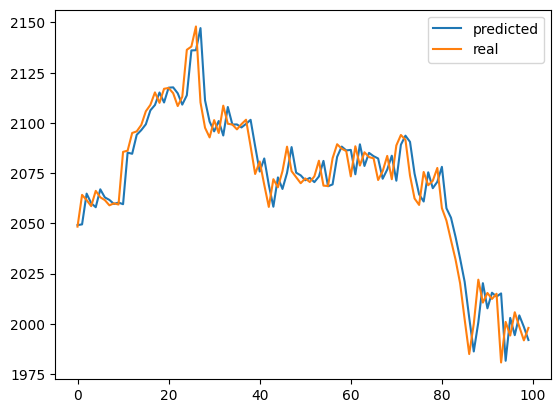

In [10]:
plt.plot(np.arange(100), predictions[-100:], label='predicted')
plt.plot(np.arange(100), base_test_y[-100:], label='real')
plt.legend()
plt.show()

На рисунке выше может показаться, что график предсказаний съехал на 1 шаг вправо.

Но если присмотреться, то модель не научилась выделять зависимость в данных и просто создает видимость предсказаний. Если смотреть с первой точки на предсказания по отдельности:
1. Модель в момент времени t=0 не предсказывает особого изменения цены на следующем шаге t=1
2. Цена резко вырастает, теперь модель предсказывает резкий рост до уровня чуть выше, чем реальное значение в момент t=1
3. В реальности же цена немного опускается в момент t=2, теперь модель предсказывает падение при t=3
4. Цена действительно опускается, модель прогнозирует дальнейший спад при t=4
5. Но теперь цена резко вырастает и т.д.

Из-за того, что предсказания находятся в области реальных значений (ведь в реальности очень редко цена меняется больше чем на 1% относительно полной стоимости акции), общая ошибка небольшая, но данная модель нас очевидно не устраивает.

# Градиентный бустинг

Попробуем построить модель градиентного бустинга и сравнить с линейной.

In [11]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

gbr_train_X = train.drop('target', axis=1)
gbr_train_y = train['target']
gbr_val_X = val.drop('target', axis=1)
gbr_val_y = val['target']
gbr_test_X = test.drop('target', axis=1)
gbr_test_y = test['target']

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [68]:
params = {
    'loss': ['squared_error', 'absolute_error', 'huber'],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [70, 100, 130],
    'max_depth': [5, 7, 9],
}

GBR = GradientBoostingRegressor()
gs_model = GridSearchCV(GBR, params)
gs_model.fit(gbr_train_X, gbr_train_y)
print(f'Best parameters: {gs_model.best_params_}')

Best parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 5, 'n_estimators': 100}


Таким образом, алгоритмом поиска гиперпараметров модели GridSearchCV были найдены следующие наборы гиперпараметров для функции потерь MSE и MAE соответственно:
- `loss`: `squared_error`
    - `learning_rate` - 0.1
    - `max_depth` - 5
    - `n_estimators` - 100
- `loss`: `absolute_error`
    - `learning_rate` - 0.1
    - `max_depth` - 8
    - `n_estimators` - 100

In [39]:
GBR = GradientBoostingRegressor(loss='squared_error', max_depth=5, n_estimators=100)
GBR.fit(gbr_train_X, gbr_train_y)

gbr_prediction = GBR.predict(gbr_val_X)
mape = mean_absolute_percentage_error(gbr_val_y, gbr_prediction)
print(f'GradientBoostingRegressor model\'s MAPE = {mape * 100:.2f}%')

GradientBoostingRegressor model's MAPE = 0.49%


In [40]:
GBR = GradientBoostingRegressor(loss='absolute_error', max_depth=8, n_estimators=100)
GBR.fit(gbr_train_X, gbr_train_y)

gbr_prediction = GBR.predict(gbr_val_X)
mape = mean_absolute_percentage_error(gbr_val_y, gbr_prediction)
print(f'GradientBoostingRegressor model\'s MAPE = {mape * 100:.2f}%')

GradientBoostingRegressor model's MAPE = 0.51%


Попробуем вернуться к исходному датасету

In [42]:
df = pd.read_csv('/kaggle/input/yandex-stock-price-1-hour-period/yandex_1hour.csv', index_col=0)
df.drop('date', axis=1, inplace=True)
df['target'] = df['close'].shift(-1)
df = df.iloc[3:-1]
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df.head()

,open,high,low,close,volume,target
0,2388.5,2390.0,2381.5,2382.0,4294,2372.5
1,2384.0,2389.5,2371.5,2372.5,12904,2376.5
2,2374.0,2379.0,2372.0,2376.5,4548,2427.5
3,2437.5,2439.0,2427.5,2427.5,2218,2474.0
4,2474.0,2474.0,2474.0,2474.0,200,2475.5


In [43]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

gbr_train_X = train.drop('target', axis=1)
gbr_train_y = train['target']
gbr_val_X = val.drop('target', axis=1)
gbr_val_y = val['target']
gbr_test_X = test.drop('target', axis=1)
gbr_test_y = test['target']

Для исходного датасета набор гиперпараметров следующий:
- `loss`: `squared_error`
    - `learning_rate` - 0.1
    - `max_depth` - 5
    - `n_estimators` - 70

In [45]:
GBR = GradientBoostingRegressor(loss='squared_error', max_depth=5, n_estimators=70)
GBR.fit(gbr_train_X, gbr_train_y)

gbr_prediction = GBR.predict(gbr_val_X)
mape = mean_absolute_percentage_error(gbr_val_y, gbr_prediction)
print(f'GradientBoostingRegressor model\'s MAPE = {mape * 100:.2f}%')

GradientBoostingRegressor model's MAPE = 0.49%


Видимой разницы между исходным и датасетом, полученным после регрессионного анализа нет.

Попробуем снова добавить скользящие средние и экспоненциальные сглаживания:

In [47]:
df = pd.read_csv('/kaggle/input/yandex-stock-price-1-hour-period/yandex_1hour.csv', index_col=0)
df.drop('date', axis=1, inplace=True)
df['open_MA'] = df['open'].rolling(window=window_size).mean()
df['high_MA'] = df['high'].rolling(window=window_size).mean()
df['low_MA'] = df['low'].rolling(window=window_size).mean()
df['close_MA'] = df['close'].rolling(window=window_size).mean()
df['volume_MA'] = df['volume'].rolling(window=window_size).mean()
df.fillna(value=0, inplace=True)
df['open_EW'] = df['open'].ewm(alpha=0.5).mean()
df['high_EW'] = df['high'].ewm(alpha=0.5).mean()
df['low_EW'] = df['low'].ewm(alpha=0.5).mean()
df['close_EW'] = df['close'].ewm(alpha=0.5).mean()
df['volume_EW'] = df['volume'].ewm(alpha=0.5).mean()
df['target'] = df['close'].shift(-1)
df = df.iloc[3:-1]
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df.head()

,open,high,low,close,volume,open_MA,high_MA,low_MA,close_MA,volume_MA,open_EW,high_EW,low_EW,close_EW,volume_EW,target
0,2388.5,2390.0,2381.5,2382.0,4294,2384.250,2389.875,2379.875,2385.125,2253.0,2386.466667,2390.866667,2381.266667,2384.333333,3057.066667,2372.5
1,2384.0,2389.5,2371.5,2372.5,12904,2385.750,2391.000,2379.000,2382.000,5270.0,2385.193548,2390.161290,2376.225806,2378.225806,8139.354839,2376.5
2,2374.0,2379.0,2372.0,2376.5,4548,2382.875,2388.250,2377.000,2379.875,5799.5,2379.507937,2384.492063,2374.079365,2377.349206,6315.174603,2427.5
3,2437.5,2439.0,2427.5,2427.5,2218,2396.000,2399.375,2388.125,2389.625,5991.0,2408.732283,2411.960630,2401.000000,2402.622047,4250.456693,2474.0
4,2474.0,2474.0,2474.0,2474.0,200,2417.375,2420.375,2411.250,2412.625,4967.5,2441.494118,2443.101961,2437.643137,2438.450980,2217.286275,2475.5


In [48]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

gbr_train_X = train.drop('target', axis=1)
gbr_train_y = train['target']
gbr_val_X = val.drop('target', axis=1)
gbr_val_y = val['target']
gbr_test_X = test.drop('target', axis=1)
gbr_test_y = test['target']

In [49]:
GBR = GradientBoostingRegressor(loss='squared_error', max_depth=5, n_estimators=70)
GBR.fit(gbr_train_X, gbr_train_y)

gbr_prediction = GBR.predict(gbr_val_X)
mape = mean_absolute_percentage_error(gbr_val_y, gbr_prediction)
print(f'GradientBoostingRegressor model\'s MAPE = {mape * 100:.2f}%')

GradientBoostingRegressor model's MAPE = 0.50%


Вероятно, алгоритм переобучился и поэтому метрика на валидационной выборке стала хуже.

Предлагаю вернуться к датасету, полученному после регрессионного анализа, а также выбрать модель с функцией потерь MSE и посмотреть на значение метрики на тестовой выборке.

In [13]:
df = pd.read_csv('/kaggle/input/yandex-stock-price-1-hour-period/yandex_1hour.csv', index_col=0)
df.drop(['date', 'open', 'high', 'low', 'volume'], axis=1, inplace=True)
df['close_EW'] = df['close'].ewm(alpha=0.5).mean()
df['close_MA'] = df['close'].rolling(window=window_size).mean()
df['target'] = df['close'].shift(-1)
df = df.iloc[3:-1]
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df.head()

,close,close_EW,close_MA,target
0,2382.0,2384.333333,2385.125,2372.5
1,2372.5,2378.225806,2382.000,2376.5
2,2376.5,2377.349206,2379.875,2427.5
3,2427.5,2402.622047,2389.625,2474.0
4,2474.0,2438.450980,2412.625,2475.5


In [16]:
GBR = GradientBoostingRegressor(loss='squared_error', max_depth=5, n_estimators=100)
GBR.fit(gbr_train_X, gbr_train_y)

gbr_prediction = GBR.predict(gbr_test_X)
mape = mean_absolute_percentage_error(gbr_test_y, gbr_prediction)
print(f'GradientBoostingRegressor model\'s MAPE = {mape * 100:.2f}%')

GradientBoostingRegressor model's MAPE = 0.35%


Хоть значение метрики улучшилось на тестовой выборке и явно меньше среднего значения изменения цены в последнее время, все равно оно хуже, чем у линейной регрессии.

Вероятно, причина кроется в специфике предметной области, где тренды обычно представляют из себя линейнeйную зависимость значения от времени.

## Визуализация результата

Не смотря на худшее значение метрики, возможно градиентному бустингу удалось найти зависимость в данных.

Поэтому давайте построим график.

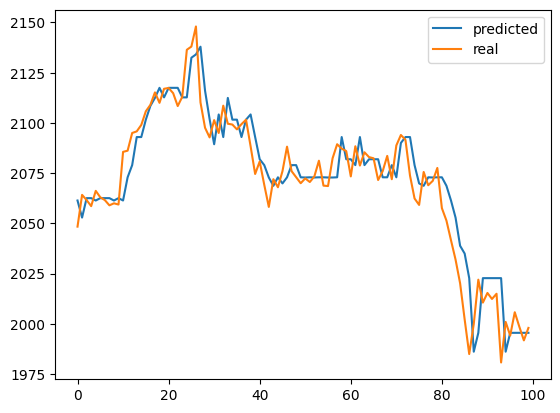

In [17]:
plt.plot(np.arange(100), gbr_prediction[-100:], label='predicted')
plt.plot(np.arange(100), gbr_test_y[-100:], label='real')
plt.legend()
plt.show()

В данном случае видно, что модель не пытается создавать ощущение предсказания, а действительно выделяет некоторую зависимость.

Если посмотреть на предсказания по отдельности, даже после относительно большого промаха, модель не пытается гнаться за реальными значениями, а предсказывает следующее значение (что и требуется от нее).

# Рекуррентные нейронные сети

## Подготовка данных

Вернемся к датасету, содержащему максимальное количество информации без количества сделок (volume), но таргет будем выделять позже самостоятельно. В ходе обучения нейросеть сама поймет на что стоит ориентироваться, т.к. возможно, что в данных заложена более сложная зависимость, которую не смогли определить линейная регрессия и градиентный бустинг.

In [18]:
df = pd.read_csv('/kaggle/input/yandex-stock-price-1-hour-period/yandex_1hour.csv', index_col=0)
df.drop(['date', 'volume'], axis=1, inplace=True)
df['open_MA'] = df['open'].rolling(window=window_size).mean()
df['high_MA'] = df['high'].rolling(window=window_size).mean()
df['low_MA'] = df['low'].rolling(window=window_size).mean()
df['close_MA'] = df['close'].rolling(window=window_size).mean()
df.fillna(value=0, inplace=True)
df['open_EW'] = df['open'].ewm(alpha=0.5).mean()
df['high_EW'] = df['high'].ewm(alpha=0.5).mean()
df['low_EW'] = df['low'].ewm(alpha=0.5).mean()
df['close_EW'] = df['close'].ewm(alpha=0.5).mean()
df = df.iloc[3:-1]
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df.head()

,open,high,low,close,open_MA,high_MA,low_MA,close_MA,open_EW,high_EW,low_EW,close_EW
0,2388.5,2390.0,2381.5,2382.0,2384.250,2389.875,2379.875,2385.125,2386.466667,2390.866667,2381.266667,2384.333333
1,2384.0,2389.5,2371.5,2372.5,2385.750,2391.000,2379.000,2382.000,2385.193548,2390.161290,2376.225806,2378.225806
2,2374.0,2379.0,2372.0,2376.5,2382.875,2388.250,2377.000,2379.875,2379.507937,2384.492063,2374.079365,2377.349206
3,2437.5,2439.0,2427.5,2427.5,2396.000,2399.375,2388.125,2389.625,2408.732283,2411.960630,2401.000000,2402.622047
4,2474.0,2474.0,2474.0,2474.0,2417.375,2420.375,2411.250,2412.625,2441.494118,2443.101961,2437.643137,2438.450980


Приведем данные к одному масштабу, запоминая среднее и стандартное отклонение каждого наблюдения.

In [19]:
data_stats = np.array([df.min(axis=1), (df.max(axis=1) - df.min(axis=1))])
data_stats

array([[2379.875     , 2371.5       , 2372.        , ..., 1980.15      ,
        1980.        , 1985.26621177],
       [  10.99166667,   19.5       ,   16.25      , ...,   30.7       ,
          35.        ,   23.58378823]])

In [20]:
df = pd.DataFrame((df.to_numpy() - data_stats[0].reshape(-1, 1)) / data_stats[1].reshape(-1, 1))

In [21]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.784685,0.921152,0.147839,0.193328,0.398029,0.909780,0.000000,0.477635,0.599697,1.000000,0.126611,0.405610
1,0.641026,0.923077,0.000000,0.051282,0.730769,1.000000,0.384615,0.538462,0.702233,0.956989,0.242349,0.344913
2,0.123077,0.430769,0.000000,0.276923,0.669231,1.000000,0.307692,0.484615,0.462027,0.768742,0.127961,0.329182
3,0.970516,1.000000,0.773956,0.773956,0.154791,0.221130,0.000000,0.029484,0.405057,0.468514,0.253071,0.284954
4,1.000000,1.000000,1.000000,1.000000,0.097610,0.145418,0.000000,0.021912,0.481978,0.507601,0.420608,0.433482


Теперь данные представляют из себя числа в отрезке \[0; 1\], где 0 - минимальное, а 1 - максимальное значение каждого наблюдения (свечи) в выбранном промежутке времени (1 час).

In [188]:
# df = pd.DataFrame(df.to_numpy() * data_stats[1].reshape(-1, 1) + data_stats[0].reshape(-1, 1))

In [189]:
# df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,2388.5,2390.0,2381.5,2382.0,2384.250,2389.875,2379.875,2385.125,2386.466667,2390.866667,2381.266667,2384.333333
1,2384.0,2389.5,2371.5,2372.5,2385.750,2391.000,2379.000,2382.000,2385.193548,2390.161290,2376.225806,2378.225806
2,2374.0,2379.0,2372.0,2376.5,2382.875,2388.250,2377.000,2379.875,2379.507937,2384.492063,2374.079365,2377.349206
3,2437.5,2439.0,2427.5,2427.5,2396.000,2399.375,2388.125,2389.625,2408.732283,2411.960630,2401.000000,2402.622047
4,2474.0,2474.0,2474.0,2474.0,2417.375,2420.375,2411.250,2412.625,2441.494118,2443.101961,2437.643137,2438.450980


Аналогично предыдущим моделям разбиваем данные на тренировочную, тестовую и валидационную выборки.

Однако, на вход будем подавать сразу по 4 наблюдения (в соответствии с выбранным размером окна), формируя выборки соответствующим образом.

In [22]:
train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

In [23]:
x_train = []
y_train = []
for i in range(0, len(train) - window_size):
    input_data = train.iloc[i:(i + window_size)]
    output_data = train[3].iloc[i + window_size]  # 3 - close column
    x_train.append(input_data.to_numpy())  #.reshape(-1))
    y_train.append(output_data)
x_train = np.array(x_train)
y_train = np.array(y_train)

In [24]:
x_val = []
y_val = []
for i in range(0, len(val) - window_size):
    input_data = val.iloc[i:(i + window_size)]
    output_data = val[3].iloc[i + window_size]  # 3 - close column
    x_val.append(input_data.to_numpy())  #.reshape(-1))
    y_val.append(output_data)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [25]:
x_test = []
y_test = []
for i in range(0, len(test) - window_size):
    input_data = test.iloc[i:(i + window_size)]
    output_data = test[3].iloc[i + window_size]  # 3 - close column
    x_test.append(input_data.to_numpy())  #.reshape(-1))
    y_test.append(output_data)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [26]:
x_test

array([[[0.49295775, 1.        , 0.35211268, ..., 0.80560868,
         0.11358236, 0.42023534],
        [0.62501222, 0.88817526, 0.01096513, ..., 1.        ,
         0.02263583, 0.30523304],
        [0.45454545, 1.        , 0.        , ..., 0.80075532,
         0.18821256, 0.63489483],
        [0.851719  , 1.        , 0.0024733 , ..., 0.90749138,
         0.        , 0.35197558]],

       [[0.62501222, 0.88817526, 0.01096513, ..., 1.        ,
         0.02263583, 0.30523304],
        [0.45454545, 1.        , 0.        , ..., 0.80075532,
         0.18821256, 0.63489483],
        [0.851719  , 1.        , 0.0024733 , ..., 0.90749138,
         0.        , 0.35197558],
        [0.31654676, 0.63309353, 0.        , ..., 0.90026898,
         0.09939944, 0.32321794]],

       [[0.45454545, 1.        , 0.        , ..., 0.80075532,
         0.18821256, 0.63489483],
        [0.851719  , 1.        , 0.0024733 , ..., 0.90749138,
         0.        , 0.35197558],
        [0.31654676, 0.63309353, 0. 

In [27]:
x_test.shape

(1548, 4, 12)

In [28]:
y_test

array([0.07194245, 0.24113475, 0.27979275, ..., 0.83550489, 0.53142857,
       0.27704575])

## Построение модели с LSTM слоями

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

In [38]:
inputs = keras.Input(shape=(window_size, 12))
x = layers.LSTM(12)(inputs)
x = layers.Dense(10, activation='elu')(x)
x = layers.Dense(5, activation='elu')(x)
outputs = layers.Dense(1)(x)

In [39]:
model = keras.Model(inputs, outputs)

In [40]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
             loss=keras.losses.MeanAbsoluteError())

In [41]:
model.fit(x_train,
          y_train,
          validation_data=(x_val, y_val),
          epochs=10,
          verbose=1)

Epoch 1/10
388/388 [==============================] - 4s 5ms/step - loss: 0.2303 - val_loss: 0.2234
Epoch 2/10
388/388 [==============================] - 1s 4ms/step - loss: 0.2196 - val_loss: 0.2250
Epoch 3/10
388/388 [==============================] - 2s 4ms/step - loss: 0.2179 - val_loss: 0.2225
Epoch 4/10
388/388 [==============================] - 2s 4ms/step - loss: 0.2175 - val_loss: 0.2235
Epoch 5/10
388/388 [==============================] - 2s 4ms/step - loss: 0.2163 - val_loss: 0.2284
Epoch 6/10
388/388 [==============================] - 2s 4ms/step - loss: 0.2160 - val_loss: 0.2218
Epoch 7/10
388/388 [==============================] - 2s 4ms/step - loss: 0.2165 - val_loss: 0.2201
Epoch 8/10
388/388 [==============================] - 2s 4ms/step - loss: 0.2163 - val_loss: 0.2226
Epoch 9/10
388/388 [==============================] - 2s 4ms/step - loss: 0.2152 - val_loss: 0.2223
Epoch 10/10
388/388 [==============================] - 2s 4ms/step - loss: 0.2161 - val_loss: 0.2203

In [42]:
model.evaluate(x_test, y_test)

49/49 [==============================] - 0s 2ms/step - loss: 0.2225


0.22254310548305511

Ошибка MAE получилась равной примерно 0.22, что является более объективной оценкой качества модели по сравнению с подходом в предыдущих моделях.

In [43]:
print(f'prediction = {model.predict(x_test[0].reshape(-1, 4, 12))}')
print(f'real = {y_test[0]}')
print()
print(f'prediction = {model.predict(x_test[2].reshape(-1, 4, 12))}')
print(f'real = {y_test[2]}')
print()
print(f'prediction = {model.predict(x_test[-2].reshape(-1, 4, 12))}')
print(f'real = {y_test[-2]}')
print()
print(f'prediction = {model.predict(x_test[-1].reshape(-1, 4, 12))}')
print(f'real = {y_test[-1]}')

1/1 [==============================] - 0s 400ms/step
prediction = [[0.38116172]]
real = 0.07194244604316617

1/1 [==============================] - 0s 20ms/step
prediction = [[0.33483413]]
real = 0.279792746113995

1/1 [==============================] - 0s 27ms/step
prediction = [[0.66753143]]
real = 0.5314285714285688

1/1 [==============================] - 0s 20ms/step
prediction = [[0.4703727]]
real = 0.27704574721542424


In [44]:
lstm_predictions = model.predict(x_test)
lstm_predictions = lstm_predictions.reshape(-1) * data_stats[1, -len(lstm_predictions):] + data_stats[0, -len(lstm_predictions):]
real_data = y_test * data_stats[1, -len(y_test):] + data_stats[0, -len(y_test):]

49/49 [==============================] - 0s 2ms/step


In [45]:
m = keras.metrics.MeanAbsolutePercentageError()
m.update_state(lstm_predictions, real_data)
print(f'LSTM\'s MAPE = {m.result().numpy():.2f}%')

LSTM's MAPE = 0.20%


После масштабирования данных обратно до реальных значений, получаем MAPE = 0.20%. Это позволяет теперь сравнивать полученную модель с предыдущими.

Результат получился очевидно лучше, чем в случае линейной регрессии и градиентного бустинга.

Теперь построим график, чтобы наглядно увидеть улучшения

In [223]:
import matplotlib.pyplot as plt

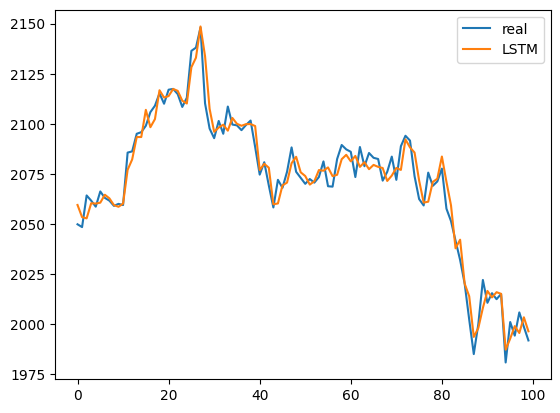

In [57]:
plt.plot(np.arange(100), real_data[-100:], label='real')
plt.plot(np.arange(100), lstm_predictions[-100:], label='LSTM')
plt.legend()
plt.show()

Как раз то, что было нужно изначально. Модель нашла нужные зависимости, но теперь ее параматры перестали быть интерпретируемыми.

Хоть и видно, что есть небольшие расхождения в некоторых моментах, но тем не менее, в большинстве случаев модель предсказывает правильную цену и характер ее изменения (рост/падение).

## Построение модели с GRU слоями

Попробуем построить аналогичную модель, но с упрощенными рекуррентными ячейками GRU.

In [47]:
inputs = keras.Input(shape=(window_size, 12))
x = layers.GRU(12)(inputs)
x = layers.Dense(10, activation='elu')(x)
x = layers.Dense(5, activation='elu')(x)
outputs = layers.Dense(1)(x)

In [48]:
model = keras.Model(inputs, outputs)

In [49]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
             loss=keras.losses.MeanAbsoluteError())

In [50]:
model.fit(x_train,
          y_train,
          validation_data=(x_val, y_val),
          epochs=10,
          verbose=1)

Epoch 1/10
388/388 [==============================] - 5s 5ms/step - loss: 0.2508 - val_loss: 0.2210
Epoch 2/10
388/388 [==============================] - 2s 4ms/step - loss: 0.2174 - val_loss: 0.2221
Epoch 3/10
388/388 [==============================] - 2s 5ms/step - loss: 0.2172 - val_loss: 0.2210
Epoch 4/10
388/388 [==============================] - 2s 5ms/step - loss: 0.2161 - val_loss: 0.2226
Epoch 5/10
388/388 [==============================] - 2s 5ms/step - loss: 0.2161 - val_loss: 0.2228
Epoch 6/10
388/388 [==============================] - 2s 5ms/step - loss: 0.2163 - val_loss: 0.2232
Epoch 7/10
388/388 [==============================] - 2s 4ms/step - loss: 0.2155 - val_loss: 0.2194
Epoch 8/10
388/388 [==============================] - 2s 4ms/step - loss: 0.2155 - val_loss: 0.2207
Epoch 9/10
388/388 [==============================] - 2s 4ms/step - loss: 0.2158 - val_loss: 0.2197
Epoch 10/10
388/388 [==============================] - 2s 5ms/step - loss: 0.2148 - val_loss: 0.2247

In [51]:
model.evaluate(x_test, y_test)

49/49 [==============================] - 0s 2ms/step - loss: 0.2254


0.22535569965839386

In [52]:
gru_predictions = model.predict(x_test)
gru_predictions = gru_predictions.reshape(-1) * data_stats[1, -len(gru_predictions):] + data_stats[0, -len(gru_predictions):]
real_data = y_test * data_stats[1, -len(y_test):] + data_stats[0, -len(y_test):]

49/49 [==============================] - 0s 2ms/step


In [53]:
m = keras.metrics.MeanAbsolutePercentageError()
m.update_state(gru_predictions, real_data)
print(f'GRU\'s MAPE = {m.result().numpy():.2f}%')

GRU's MAPE = 0.21%


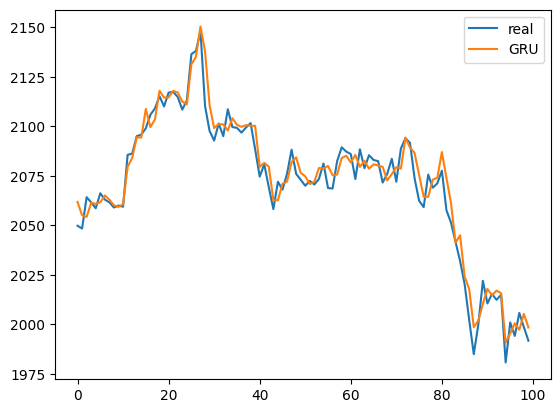

In [58]:
plt.plot(np.arange(100), real_data[-100:], label='real')
plt.plot(np.arange(100), gru_predictions[-100:], label='GRU')
plt.legend()
plt.show()

Результат также лучше по сравнению с линейной регрессией и градиентным бустингом. Однако, теперь предсказания в среднем более завышены и меньше точных совпадений.

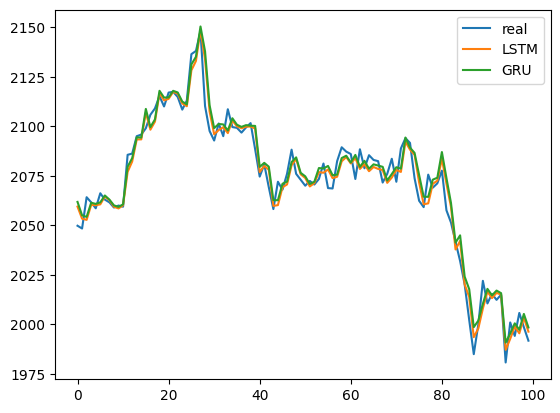

In [59]:
plt.plot(np.arange(100), real_data[-100:], label='real')
plt.plot(np.arange(100), lstm_predictions[-100:], label='LSTM')
plt.plot(np.arange(100), gru_predictions[-100:], label='GRU')
plt.legend()
plt.show()

При сравнении обеих моделей на фоне реальных данных, видно что они работают по одному и тому же принципу. Но модель с LSTM ячейками делает предсказания более близкие к реальным данным.

Возможно, модель GRU не успела до конца обучиться (или неудачно инициализаровались начальные значения весов); но, вероятнее всего, сыграли свою роль дополнительные параметры в ячейках LSTM.

## Подбор гиперпараметров

Теперь подберем гиперпараметры для модели со слоями LSTM.

In [69]:
param_grid = {
    'lstm': [16, 17, 18],
    'first': [7, 8, 9],
    'second': [6, 7, 8],
}

In [71]:
best_score = 1
best_params = []
for l in param_grid['lstm']:
    for f in param_grid['first']:
        for s in param_grid['second']:
            inputs = keras.Input(shape=(window_size, 12))
            x = layers.LSTM(l)(inputs)
            x = layers.Dense(f, activation='elu')(x)
            x = layers.Dense(s, activation='elu')(x)
            outputs = layers.Dense(1)(x)
            model = keras.Model(inputs, outputs)
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                         loss=keras.losses.MeanAbsoluteError())
            model.fit(x_train,
                      y_train,
                      epochs=10,
                      verbose=0)
            score = model.evaluate(x_val, y_val, verbose=0)
            if score < best_score:
                best_score = score
                best_params = [l, f, s]
print(best_params)

[16, 9, 7]


Запускаем поиск оптимальных гиперпараметров несколько раз, каждые 2-3 прохода корректируя диапазон рассматриваемых значений, смещаясь в сторону оптимальных значений и уменьшая ширину диапазона.

Начальный набор:
- `lstm` [8, 12, 16]
- `first` [4, 8, 12]
- `second` [4, 8, 12]
1. [16, 4, 8]
2. [16, 8, 8]
3. [14, 6, 10]
4. [16, 8, 6]
5. [18, 8, 6]
6. [18, 8, 6]
7. [16, 9, 7]

Однозначного победителя среди возможных наборов гиперпараметров выделить не получается, но можно сказать, что чаще всего для параметра `lstm` встречается значение 16, для `first` - 8, а для `second` - 6.
Теперь обучим модель заново, используя подобранные значения.

In [73]:
inputs = keras.Input(shape=(window_size, 12))
x = layers.LSTM(16)(inputs)
x = layers.Dense(8, activation='elu')(x)
x = layers.Dense(6, activation='elu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
             loss=keras.losses.MeanAbsoluteError())
model.fit(x_train,
          y_train,
          epochs=10,
          verbose=0)
score = model.evaluate(x_val, y_val, verbose=0)
print(score)

0.21985888481140137


Относительная ошибка (не абсолютная, которая берется от полной стоимости акции, а которая берется от диапазона, в котором менялись значения на предыдущем шаге) незначительно, но все-таки снизилась.
Построим график, чтобы наглядно увидеть изменения.

In [74]:
lstm_predictions = model.predict(x_test)
lstm_predictions = lstm_predictions.reshape(-1) * data_stats[1, -len(lstm_predictions):] + data_stats[0, -len(lstm_predictions):]
real_data = y_test * data_stats[1, -len(y_test):] + data_stats[0, -len(y_test):]
m = keras.metrics.MeanAbsolutePercentageError()
m.update_state(lstm_predictions, real_data)
print(f'LSTM\'s MAPE = {m.result().numpy():.2f}%')

49/49 [==============================] - 0s 2ms/step
LSTM's MAPE = 0.20%


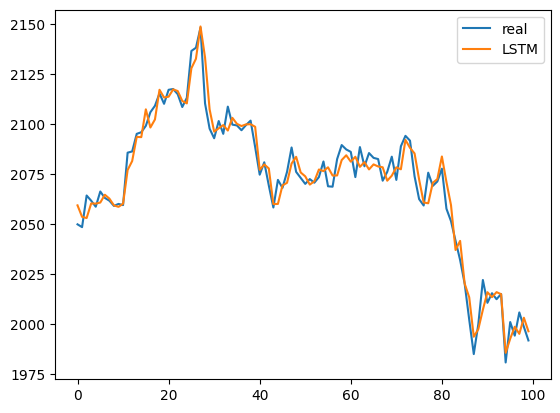

In [75]:
plt.plot(np.arange(100), real_data[-100:], label='real')
plt.plot(np.arange(100), lstm_predictions[-100:], label='LSTM')
plt.legend()
plt.show()

Визуально изменения увидеть сложно в связи с маштабированием предсказаний до реальных значений.

Теперь попробуем увеличить `window_size` и посмотрим как изменятся предсказания модели.

In [30]:
alpha = 0.5

train_size = 0.8
val_size = 0.1

In [52]:
windows = [4, 5, 6, 7, 8]

In [57]:
results = [[], [], []]
for window_size in windows:
    df = pd.read_csv('/kaggle/input/yandex-stock-price-1-hour-period/yandex_1hour.csv', index_col=0)
    df.drop(['date', 'volume'], axis=1, inplace=True)
    df['open_MA'] = df['open'].rolling(window=window_size).mean()
    df['high_MA'] = df['high'].rolling(window=window_size).mean()
    df['low_MA'] = df['low'].rolling(window=window_size).mean()
    df['close_MA'] = df['close'].rolling(window=window_size).mean()
    df.fillna(value=0, inplace=True)
    df['open_EW'] = df['open'].ewm(alpha=alpha).mean()
    df['high_EW'] = df['high'].ewm(alpha=alpha).mean()
    df['low_EW'] = df['low'].ewm(alpha=alpha).mean()
    df['close_EW'] = df['close'].ewm(alpha=alpha).mean()
    df = df.iloc[3:-1]
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)

    data_stats = np.array([df.min(axis=1), (df.max(axis=1) - df.min(axis=1))])
    df = pd.DataFrame((df.to_numpy() - data_stats[0].reshape(-1, 1)) / data_stats[1].reshape(-1, 1))

    train = df[:int(len(df) * train_size)]
    val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
    test = df[int(len(df) * (train_size + val_size)):]

    x_train = []
    y_train = []
    for i in range(0, len(train) - window_size):
        input_data = train.iloc[i:(i + window_size)]
        output_data = train[3].iloc[i + window_size]  # 3 - close column
        x_train.append(input_data.to_numpy())  #.reshape(-1))
        y_train.append(output_data)
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    x_val = []
    y_val = []
    for i in range(0, len(val) - window_size):
        input_data = val.iloc[i:(i + window_size)]
        output_data = val[3].iloc[i + window_size]  # 3 - close column
        x_val.append(input_data.to_numpy())  #.reshape(-1))
        y_val.append(output_data)
    x_val = np.array(x_val)
    y_val = np.array(y_val)

    x_test = []
    y_test = []
    for i in range(0, len(test) - window_size):
        input_data = test.iloc[i:(i + window_size)]
        output_data = test[3].iloc[i + window_size]  # 3 - close column
        x_test.append(input_data.to_numpy())  #.reshape(-1))
        y_test.append(output_data)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    inputs = keras.Input(shape=(window_size, 12))
    x = layers.LSTM(16)(inputs)
    x = layers.Dense(8, activation='elu')(x)
    x = layers.Dense(6, activation='elu')(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                 loss=keras.losses.MeanAbsoluteError())
    model.fit(x_train,
              y_train,
              epochs=10,
              verbose=0)
    results[0].append(model.evaluate(x_train, y_train, verbose=0))
    results[1].append(model.evaluate(x_test, y_test, verbose=0))
    
    lstm_predictions = model.predict(x_test)
    lstm_predictions = lstm_predictions.reshape(-1) * data_stats[1, -len(lstm_predictions):] + data_stats[0, -len(lstm_predictions):]
    real_data = y_test * data_stats[1, -len(y_test):] + data_stats[0, -len(y_test):]
    m = keras.metrics.MeanAbsolutePercentageError()
    m.update_state(lstm_predictions, real_data)
    results[2].append(m.result().numpy())

49/49 [==============================] - 1s 2ms/step


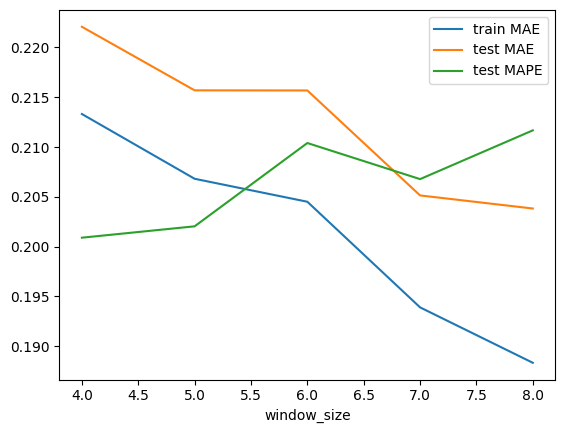

In [58]:
plt.plot(windows, results[0], label='train MAE')
plt.plot(windows, results[1], label='test MAE')
plt.plot(windows, results[2], label='test MAPE')
plt.xlabel('window_size')
plt.ylabel('')
plt.legend()
plt.show()

На графике выше видно, что с увеличением размера окна, ошибка предсказаний на масштабированных данных уменьшается (и тренировочная, и тестовая), а на данных в реальном масштабе MAPE увеличивается.

При 5 разных запусках значения ошибок немного отличаются, но всегда ошибка на масштабированных данных монотонно уменьшается, а MAPE на реальных данных не сильно отличается при значениях 4 и 5, а затем резко вырастает.

Поскольку нас в первую очередь интересуют реальные данные, предлагаю взять размер окна равным 5.

In [59]:
window_size = 5

In [60]:
df = pd.read_csv('/kaggle/input/yandex-stock-price-1-hour-period/yandex_1hour.csv', index_col=0)
df.drop(['date', 'volume'], axis=1, inplace=True)
df['open_MA'] = df['open'].rolling(window=window_size).mean()
df['high_MA'] = df['high'].rolling(window=window_size).mean()
df['low_MA'] = df['low'].rolling(window=window_size).mean()
df['close_MA'] = df['close'].rolling(window=window_size).mean()
df.fillna(value=0, inplace=True)
df['open_EW'] = df['open'].ewm(alpha=alpha).mean()
df['high_EW'] = df['high'].ewm(alpha=alpha).mean()
df['low_EW'] = df['low'].ewm(alpha=alpha).mean()
df['close_EW'] = df['close'].ewm(alpha=alpha).mean()
df = df.iloc[3:-1]
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

data_stats = np.array([df.min(axis=1), (df.max(axis=1) - df.min(axis=1))])
df = pd.DataFrame((df.to_numpy() - data_stats[0].reshape(-1, 1)) / data_stats[1].reshape(-1, 1))

train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

x_train = []
y_train = []
for i in range(0, len(train) - window_size):
    input_data = train.iloc[i:(i + window_size)]
    output_data = train[3].iloc[i + window_size]  # 3 - close column
    x_train.append(input_data.to_numpy())  #.reshape(-1))
    y_train.append(output_data)
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = []
y_val = []
for i in range(0, len(val) - window_size):
    input_data = val.iloc[i:(i + window_size)]
    output_data = val[3].iloc[i + window_size]  # 3 - close column
    x_val.append(input_data.to_numpy())  #.reshape(-1))
    y_val.append(output_data)
x_val = np.array(x_val)
y_val = np.array(y_val)

x_test = []
y_test = []
for i in range(0, len(test) - window_size):
    input_data = test.iloc[i:(i + window_size)]
    output_data = test[3].iloc[i + window_size]  # 3 - close column
    x_test.append(input_data.to_numpy())  #.reshape(-1))
    y_test.append(output_data)
x_test = np.array(x_test)
y_test = np.array(y_test)

inputs = keras.Input(shape=(window_size, 12))
x = layers.LSTM(16)(inputs)
x = layers.Dense(8, activation='elu')(x)
x = layers.Dense(6, activation='elu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
             loss=keras.losses.MeanAbsoluteError())
model.fit(x_train,
          y_train,
          epochs=10,
          verbose=0)

In [61]:
lstm_predictions = model.predict(x_test)
lstm_predictions = lstm_predictions.reshape(-1) * data_stats[1, -len(lstm_predictions):] + data_stats[0, -len(lstm_predictions):]
real_data = y_test * data_stats[1, -len(y_test):] + data_stats[0, -len(y_test):]
m = keras.metrics.MeanAbsolutePercentageError()
m.update_state(lstm_predictions, real_data)
print(f'LSTM\'s MAPE = {m.result().numpy():.2f}%')

49/49 [==============================] - 1s 2ms/step
LSTM's MAPE = 0.20%


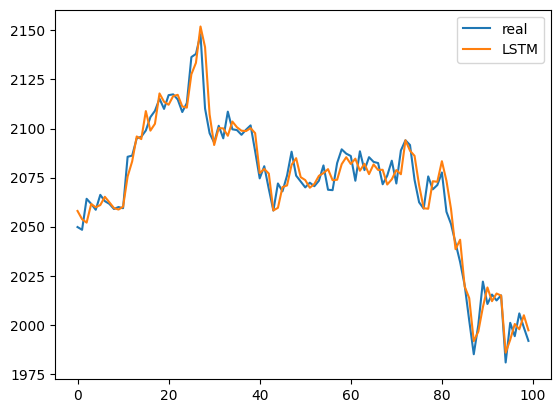

In [62]:
plt.plot(np.arange(100), real_data[-100:], label='real')
plt.plot(np.arange(100), lstm_predictions[-100:], label='LSTM')
plt.legend()
plt.show()

# ARIMA

Загружаем библиотеку для подбора параметров.

In [63]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.8 MB/s eta 0:00:0000:0100:01


In [64]:
from pmdarima import auto_arima

Берем изначальный датасет, нам из него нужно будет только `close`.

In [65]:
df = pd.read_csv('/kaggle/input/yandex-stock-price-1-hour-period/yandex_1hour.csv', index_col=0)

train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

Подбираем параметры

In [73]:
auto_arima_results = auto_arima(train['close'])
print(auto_arima_results)

 ARIMA(5,2,0)(0,0,0)[0]          


In [67]:
from statsmodels.tsa.arima.model import ARIMA

Обучаем модель

In [74]:
model = ARIMA(train['close'], order=(5,2,0), seasonal_order=(0,0,0,0))
model = model.fit()

In [75]:
start = train.shape[0] + val.shape[0] + test.shape[0] - 101
end = train.shape[0] + val.shape[0] + test.shape[0] - 1
pred = model.predict(start=start, end=end)

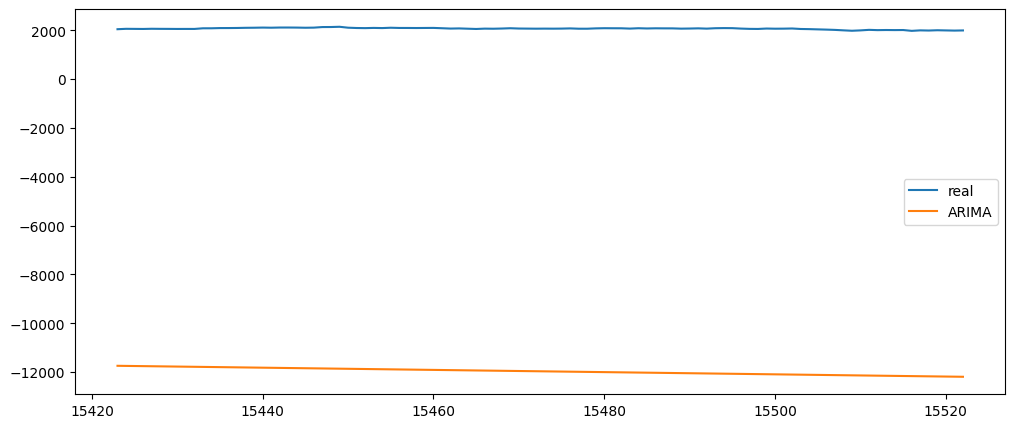

In [78]:
test['close'].iloc[-100:].plot(figsize=(12,5), legend=True, label='real')
pred.iloc[-100:].plot(legend=True, label='ARIMA')
plt.show()

Вероятно, из-за специфики предметной области и отсутствия часто повторяющихся паттернов в изменении стоимости акций, модель ARIMA плохо подходит для решения поставленной задачи. Ее результаты даже не будем рассматривать, поскольку очевидно отсутствие каких-либо совпадений в данных.

# Оценка моделей

## Выбор метрик

Перед тем, как выбрать метрику для сравнения всех моделей между собой, стоит понять как именно изменяется цена со временем.

Во-первых, стоит отметить, что закон, по которому изменяется стоимость акций на бирже, по мнению некоторых людей, является логнормальным. Вероятно, функция потерь MSE неплохо справилась бы с задачей подбора параметров для модели, описывающей рассматриваемые данные, поскольку вероятность сильного изменения цены за единицу времени меньше, чем вероятность того, что цена останется в области предыдущих значений.
Однако, поставленная изначально задача заключается в определении не точной стоимости акций, а в определении характера и силы изменения цены. Поэтому, штрафовать модель квадратом расстояния между реальным и предсказанным значением видится несколько неразумным.

Можно выделить 5 типов предсказаний относительно предыдущего значения:
1. Сильный рост
2. Слабый рост
3. Отсутствие особых изменений
4. Слабое падение
5. Сильное падение

Представим, что модель предсказала небольшой, но ощутимый с точки зрения целесообразности покупки рост, поэтому мы купили некоторое количество акций; а в реальности, допустим, рост был больше, чем изначально предсказывала модель. Получается что мы заработали, но больше, чем планировали - это хорошо. Если же модель предсказала сильный рост, а в реальности он был не таким, но стоимость все равно выросла, то получается, что мы зря рисковали, но все равно ничего не потеряли. Аналогично ситуация обстоит с падением стоимости. Если же модель предсказывает падение, а в реальности цена растет (и наоборот), то здесь уже не важна величина изменения стоимости, важнее, что мы не угадали характер изменения.

Поэтому будем использовать функцию потерь MAE, а в качестве метрики MAE с проверкой совпадения характера изменения стоимости, но также стоит обратить внимание на следующий нюанс при оценке результатов (при выборе метрики):

В реальности, для того, чтобы принять решение о покупке или продаже акций, важно, чтобы модель умела определять случаи, в которых цена будет ощутимо изменяться (например, 2 часа стоимость была на одном уровне, а потом начинает падать/расти). То есть ценнее тот прогноз, который строится успешно в случае дальнейшего ощутимого роста/падения.

Таким образом, предлагаю ввести собственную метрику для итоговой оценки модели "взвешенное MAE с проверкой характера изменения стоимости":

$$Error =
\left\{
    \begin{array}{ll}
        |Pred_k - Real_{k-1}| * \frac{|Real_k - Real_{k-1}|}{Mean_{k-t, k}}  & \mbox{if } (Pred_k - Real_{k-1}) * (Real_k - Real_{k-1}) \gt 0 \\
        (Pred_k - Real_{k-1})^2 * \frac{|Real_k - Real_{k-1}|}{Mean_{k-t, k}} & \mbox{if } (Pred_k - Real_{k-1}) * (Real_k - Real_{k-1}) \lt 0
    \end{array}
\right.$$

## Сравнение моделей

In [1]:
import numpy as np
import pandas as pd

In [2]:
train_size = 0.8
val_size = 0.1

In [17]:
df = pd.read_csv('/kaggle/input/yandex-stock-price-1-hour-period/yandex_1hour.csv', index_col=0)
df['target'] = df['close'].shift(-1)
df['diff'] = np.abs(df['target'] - df['close'])
df['mean_diff'] = df['diff'].rolling(window=100).mean()
# df['mean_target'] = df['target'].rolling(window=100).mean()
# df['mean_diff'] = df['mean_diff'] / df['mean_target']
df['k'] = df['diff'] / df['mean_diff']
df = pd.DataFrame(df[['close', 'target', 'k']])
df = df.iloc[3:-1]
df = df[int(len(df) * (train_size + val_size)):]
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

eq = df.copy()
eq.tail()

,close,target,k
1547,2001.0,1994.2,0.802076
1548,1994.2,2005.8,1.381281
1549,2005.8,1998.6,0.855107
1550,1998.6,1991.8,0.803593
1551,1991.8,1998.0,0.743227


### Базовая модель

In [4]:
from sklearn.linear_model import LinearRegression

In [19]:
window_size = 4
alpha = 0.5

df = pd.read_csv('/kaggle/input/yandex-stock-price-1-hour-period/yandex_1hour.csv', index_col=0)
df.drop(['date', 'open', 'high', 'low', 'volume'], axis=1, inplace=True)
df['close_EW'] = df['close'].ewm(alpha=alpha).mean()
df['close_MA'] = df['close'].rolling(window=window_size).mean()
df['target'] = df['close'].shift(-1)
df = df.iloc[3:-1]
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

base_train_X = train.drop('target', axis=1)
base_train_y = train['target']
base_val_X = val.drop('target', axis=1)
base_val_y = val['target']
base_test_X = test.drop('target', axis=1)
base_test_y = test['target']


In [20]:
base_model = LinearRegression()
base_model.fit(base_train_X, base_train_y)
predictions = base_model.predict(base_test_X)

In [21]:
eq['base_pred'] = predictions
eq['base_diff'] = np.abs(eq['base_pred'] - eq['target'])
eq['base_check'] = ((eq['target'] - eq['close']) * (eq['base_pred'] - eq['close']) > 0)
eq['base_werror'] = eq['k'] * eq['base_diff'] ** (2 - eq['base_check'])
eq.head()

,close,target,k,base_pred,base_diff,base_check,base_werror
0,1836.4,1834.0,0.422238,1836.241954,2.241954,True,0.946638
1,1834.0,1842.6,1.505602,1834.146566,8.453434,True,12.727510
2,1842.6,1831.6,1.909722,1842.919079,11.319079,False,244.676570
3,1831.6,1828.2,0.590073,1831.547795,3.347795,True,1.975443
4,1828.2,1817.8,1.829054,1828.828834,11.028834,False,222.477271


### Градиентный бустинг

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

In [22]:
window_size = 4
alpha = 0.5

df = pd.read_csv('/kaggle/input/yandex-stock-price-1-hour-period/yandex_1hour.csv', index_col=0)
df.drop(['date', 'open', 'high', 'low', 'volume'], axis=1, inplace=True)
df['close_EW'] = df['close'].ewm(alpha=0.5).mean()
df['close_MA'] = df['close'].rolling(window=window_size).mean()
df['target'] = df['close'].shift(-1)
df = df.iloc[3:-1]
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

gbr_train_X = train.drop('target', axis=1)
gbr_train_y = train['target']
gbr_val_X = val.drop('target', axis=1)
gbr_val_y = val['target']
gbr_test_X = test.drop('target', axis=1)
gbr_test_y = test['target']

In [23]:
GBR = GradientBoostingRegressor(loss='squared_error', max_depth=5, n_estimators=100)
GBR.fit(gbr_train_X, gbr_train_y)
predictions = GBR.predict(gbr_test_X)

In [24]:
eq['gbr_pred'] = predictions
eq['gbr_diff'] = np.abs(eq['gbr_pred'] - eq['target'])
eq['gbr_check'] = ((eq['target'] - eq['close']) * (eq['gbr_pred'] - eq['close']) > 0)
eq['gbr_werror'] = eq['k'] * eq['gbr_diff'] ** (2 - eq['gbr_check'])
eq.head()

,close,target,k,base_pred,base_diff,base_check,base_werror,gbr_pred,gbr_diff,gbr_check,gbr_werror
0,1836.4,1834.0,0.422238,1836.241954,2.241954,True,0.946638,1842.665165,8.665165,False,31.703762
1,1834.0,1842.6,1.505602,1834.146566,8.453434,True,12.727510,1842.665165,0.065165,True,0.098112
2,1842.6,1831.6,1.909722,1842.919079,11.319079,False,244.676570,1843.599740,11.999740,False,274.988093
3,1831.6,1828.2,0.590073,1831.547795,3.347795,True,1.975443,1842.665165,14.465165,False,123.467433
4,1828.2,1817.8,1.829054,1828.828834,11.028834,False,222.477271,1830.897604,13.097604,False,313.769122


### RNN с LSTM слоем

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

In [37]:
window_size = 4
alpha = 0.5

df = pd.read_csv('/kaggle/input/yandex-stock-price-1-hour-period/yandex_1hour.csv', index_col=0)
df.drop(['date', 'volume'], axis=1, inplace=True)
df['open_MA'] = df['open'].rolling(window=window_size).mean()
df['high_MA'] = df['high'].rolling(window=window_size).mean()
df['low_MA'] = df['low'].rolling(window=window_size).mean()
df['close_MA'] = df['close'].rolling(window=window_size).mean()
df.fillna(value=0, inplace=True)
df['open_EW'] = df['open'].ewm(alpha=alpha).mean()
df['high_EW'] = df['high'].ewm(alpha=alpha).mean()
df['low_EW'] = df['low'].ewm(alpha=alpha).mean()
df['close_EW'] = df['close'].ewm(alpha=alpha).mean()
df = df.iloc[3:-1]
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

data_stats = np.array([df.min(axis=1), (df.max(axis=1) - df.min(axis=1))])
df = pd.DataFrame((df.to_numpy() - data_stats[0].reshape(-1, 1)) / data_stats[1].reshape(-1, 1))

train = df[:int(len(df) * train_size)]
val = df[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
test = df[int(len(df) * (train_size + val_size)):]

x_list = []
y_list = []
for i in range(0, len(df) - window_size):
    input_data = df.iloc[i:(i + window_size)]
    output_data = df[3].iloc[i + window_size]  # 3 - close column
    x_list.append(input_data.to_numpy())  #.reshape(-1))
    y_list.append(output_data)
x_list = np.array(x_list)
y_list = np.array(y_list)

x_train = x_list[:int(len(df) * train_size)]
y_train = y_list[:int(len(df) * train_size)]
x_val = x_list[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
y_val = y_list[int(len(df) * train_size):int(len(df) * (train_size + val_size))]
x_test = x_list[-1552:]
y_test = y_list[-1552:]

In [38]:
inputs = keras.Input(shape=(window_size, 12))
x = layers.LSTM(16)(inputs)
x = layers.Dense(8, activation='elu')(x)
x = layers.Dense(6, activation='elu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
             loss=keras.losses.MeanAbsoluteError())
model.fit(x_train,
          y_train,
          epochs=10,
          verbose=0)

lstm_predictions = model.predict(x_test, verbose=0)
lstm_predictions = lstm_predictions.reshape(-1) * data_stats[1, -len(lstm_predictions):] + data_stats[0, -len(lstm_predictions):]
real_data = y_test * data_stats[1, -len(y_test):] + data_stats[0, -len(y_test):]

In [39]:
eq['lstm_pred'] = lstm_predictions
eq['lstm_diff'] = np.abs(eq['lstm_pred'] - eq['target'])
eq['lstm_check'] = ((eq['target'] - eq['close']) * (eq['lstm_pred'] - eq['close']) > 0)
eq['lstm_werror'] = eq['k'] * eq['lstm_diff'] ** (2 - eq['lstm_check'])
eq.head()

,close,target,k,base_pred,base_diff,base_check,base_werror,gbr_pred,gbr_diff,gbr_check,gbr_werror,lstm_pred,lstm_diff,lstm_check,lstm_werror
0,1836.4,1834.0,0.422238,1836.241954,2.241954,True,0.946638,1842.665165,8.665165,False,31.703762,1837.386407,3.386407,False,4.842120
1,1834.0,1842.6,1.505602,1834.146566,8.453434,True,12.727510,1842.665165,0.065165,True,0.098112,1836.420099,6.179901,True,9.304473
2,1842.6,1831.6,1.909722,1842.919079,11.319079,False,244.676570,1843.599740,11.999740,False,274.988093,1833.721702,2.121702,True,4.051862
3,1831.6,1828.2,0.590073,1831.547795,3.347795,True,1.975443,1842.665165,14.465165,False,123.467433,1839.502617,11.302617,False,75.381312
4,1828.2,1817.8,1.829054,1828.828834,11.028834,False,222.477271,1830.897604,13.097604,False,313.769122,1832.958230,15.158230,False,420.265246


### Сравнительный анализ

In [40]:
print(f'''
Base model:
В {np.sum(eq['base_check']) / len(eq) * 100 :.2f}% случаев успешно предсказала характер изменения стоимости
Взвешенная ошибка = {np.mean(eq['base_werror']) :.3f}

GradientBoosting model:
В {np.sum(eq['gbr_check']) / len(eq) * 100 :.2f}% случаев успешно предсказала характер изменения стоимости
Взвешенная ошибка = {np.mean(eq['gbr_werror']) :.3f}

RNN with LSTM layer:
В {np.sum(eq['lstm_check']) / len(eq) * 100 :.2f}% случаев успешно предсказала характер изменения стоимости
Взвешенная ошибка = {np.mean(eq['lstm_werror']) :.3f}
''')


Base model:
В 52.13% случаев успешно предсказала характер изменения стоимости
Взвешенная ошибка = 177.439

GradientBoosting model:
В 50.77% случаев успешно предсказала характер изменения стоимости
Взвешенная ошибка = 183.023

RNN with LSTM layer:
В 57.02% случаев успешно предсказала характер изменения стоимости
Взвешенная ошибка = 189.228

